In [5]:
from matplotlib import pyplot as plt
from whar_datasets.adapters.sampler import Sampler
from whar_datasets.support.getter import WHARDatasetID, get_dataset_cfg

In [7]:
cfg = get_dataset_cfg(WHARDatasetID.WHAR)

cfg.parallelize = False
cfg.in_memory = False
force_recompute = False
# force_recompute = [False, True, True]

sampler = Sampler(cfg, force_recompute)

2025-11-21 11:08:00,707 - whar-datasets - INFO - Running DownloadingStep
2025-11-21 11:08:00,710 - whar-datasets - INFO - Checking hash for DownloadingStep
2025-11-21 11:08:00,714 - whar-datasets - INFO - Hash is up to date
2025-11-21 11:08:00,716 - whar-datasets - INFO - Running ParsingStep
2025-11-21 11:08:00,723 - whar-datasets - INFO - Checking hash for ParsingStep
2025-11-21 11:08:00,730 - whar-datasets - INFO - Hash is up to date
2025-11-21 11:08:00,732 - whar-datasets - INFO - Running WindowingStep
2025-11-21 11:08:00,736 - whar-datasets - INFO - Checking hash for WindowingStep
2025-11-21 11:08:00,743 - whar-datasets - INFO - Hash is up to date
2025-11-21 11:08:00,745 - whar-datasets - INFO - Loading windowing


2025-11-21 11:08:00,789 - whar-datasets - INFO - activity_ids from 0 to 8
2025-11-21 11:08:00,792 - whar-datasets - INFO - subject_ids from 0 to 21


In [8]:
sampler.prepare(scv_group_index=0)

2025-11-21 11:08:03,333 - whar-datasets - INFO - train: 6150 | test: 5916
2025-11-21 11:08:03,336 - whar-datasets - INFO - Running SamplingStep
2025-11-21 11:08:03,336 - whar-datasets - INFO - Checking hash for SamplingStep
2025-11-21 11:08:03,336 - whar-datasets - INFO - Hash is not up to date
Loading windows: 100%|██████████| 12066/12066 [00:31<00:00, 386.12it/s]
2025-11-21 11:08:34,602 - whar-datasets - INFO - Computing samples
2025-11-21 11:08:34,602 - whar-datasets - INFO - Getting normalization parameters
2025-11-21 11:08:35,013 - whar-datasets - INFO - Normalizing and transforming windows
Normalizing and transforming windows: 100%|██████████| 12066/12066 [00:42<00:00, 284.77it/s]
2025-11-21 11:09:17,389 - whar-datasets - INFO - Saving samples
Caching samples: 100%|██████████| 12066/12066 [00:31<00:00, 378.61it/s]


In [9]:
weights = sampler.get_class_weights(sampler.train_indices)
print(weights)

{0: 0.19535628851612283, 2: 0.3208184382520328, 3: 0.41130569006670875, 6: 0.5844870332526914, 1: 1.1020480703314106, 7: 2.0822350559627134, 8: 2.3037494236183207, 4: -1, 5: -1}


torch.Size([1]) torch.Size([1, 320, 6])


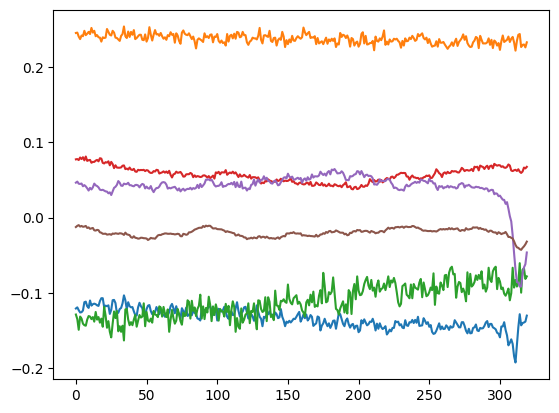

In [10]:
y, x = sampler.sample(1, sampler.train_indices, subject_id=5, activity_id=3, seed=None)
print(y.shape, x.shape)

plt.plot(x[0])
plt.show()

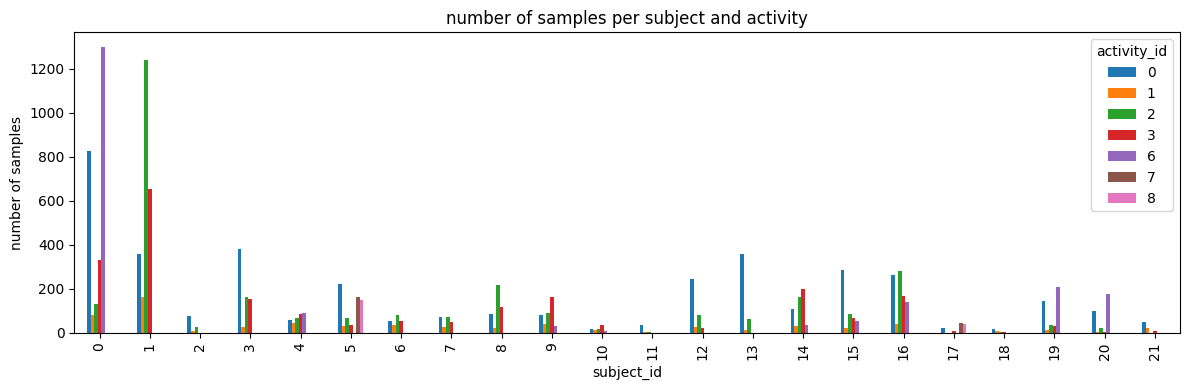

In [11]:
sampler.plot_indices_statistics(sampler.train_indices + sampler.test_indices)

In [12]:
subset = sampler.window_metadata.iloc[sampler.train_indices]

# Merge with session_metadata to get subject_id info
merged = subset.merge(
    sampler.session_metadata[["session_id", "subject_id", "activity_id"]],
    on="session_id",
    how="left",
)

subject_ids = merged["subject_id"].unique().tolist()
print(subject_ids)
subject_ids = subject_ids[:4]

print(merged.value_counts("activity_id"))

[4, 5, 6, 7, 8, 17, 18, 19, 20, 21, 11, 12, 13, 9, 10, 14, 15, 16]
activity_id
0    2217
2    1350
3    1053
6     741
1     393
7     208
8     188
Name: count, dtype: int64


In [13]:
subject_map = {}

for sub in subject_ids:
    _, samples = sampler.sample(20, sampler.train_indices, activity_id=1, subject_id=5)
    subject_map[sub] = samples  # (32, 128, 9)


c:\Users\hohma\Teco\whar-datasets\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


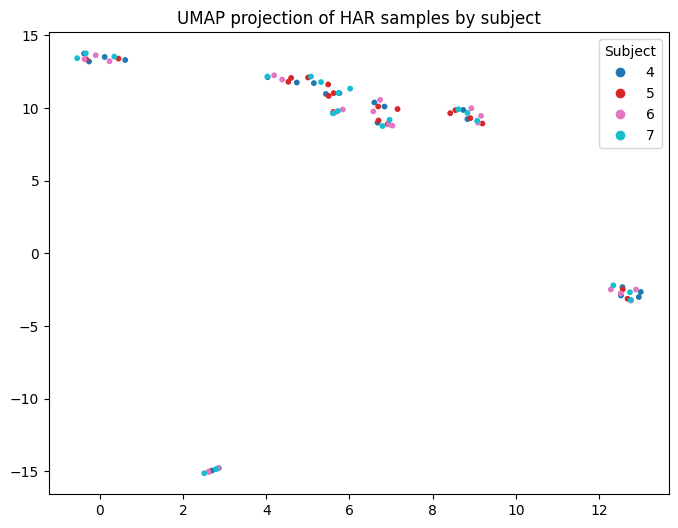

In [14]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# Assuming subject_map[sub] = array of shape (32, 128, 9)

X_list = []
y_list = []

for sub, samples in subject_map.items():
    # Flatten each sequence from (128, 9) → (1152,)
    flat_samples = samples.reshape(samples.shape[0], -1)

    X_list.append(flat_samples)
    y_list.extend([sub] * samples.shape[0])  # label with subject id

# Stack into single dataset
X = np.vstack(X_list)  # shape (num_subjects * 32, 1152)
y = np.array(y_list)

# Run UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Plot with subjects in different colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap="tab10", s=10)
plt.legend(*scatter.legend_elements(), title="Subject")
plt.title("UMAP projection of HAR samples by subject")
plt.show()